In [1]:
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tikzplotlib as tkz
import warnings
warnings.filterwarnings("ignore")

import os, sys

_, filename = os.path.split(os.getcwd())
if filename == 'notebooks':
    old_dir = os.getcwd()
    os.chdir('../')
    print('Moving Current Directory from ' + old_dir + ' to ' + os.getcwd())
else:
    print('Current Directory is ' + os.getcwd())

sys.path.append('./')  

from FRB.agents import UCB1Agent, FactoredUCBAgent, TMRobustUCBAgent #, FactoredUCBAgentMM
from FRB.env import FactoredEnv
from FRB.utils import get_pulled_expected, compute_max_expected, create_action_matrix, get_sigma_square_eq_max

Moving Current Directory from /home/simone/Projects/research/FRB/notebooks to /home/simone/Projects/research/FRB


In [2]:
'''
class FactoredUCBAgentMM():
    """
    This class implements the FRB MM optimal algorithm in its anytime
    version for bounded variables
    """
    def __init__(self, n_arms_vect, dim, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4):
        self.n_arms_vect = n_arms_vect
        self.dim = dim
        self.T = time_horizon
        assert self.dim == self.n_arms_vect.shape[0]
        self.max_reward = max_reward
        self.sigma = sigma
        self.exploration_alpha = exploration_alpha
        self.num_actions = np.prod(self.n_arms_vect)
        self.action_matrix = np.zeros(
            (self.num_actions, dim), dtype=int
        )
        for i in range(self.dim):
            vect = -1 * np.ones(np.prod(self.n_arms_vect[:i+1]))
            external_repeats = int(np.prod(self.n_arms_vect) / len(vect))
            internal_repeats = max(1, int(np.prod(self.n_arms_vect[:i])))
            for j in range(self.n_arms_vect[i]):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        print(self.action_matrix)
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions)
        self.n_pulls = []
        self.observations = []
        for size in self.n_arms_vect:
            self.n_pulls.append(np.zeros(size, dtype=int))
            self.observations.append(-1 * np.ones((self.T, size), dtype=int))
        return self

    def pull_arm(self):
        ucb = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_vector = self.action_matrix[i, :]
            self.n_min_pull[i] = self.n_pulls[0][action_vector[0]]
            for j in range(1, self.dim):
                self.n_min_pull[i] = min(self.n_min_pull[i], self.n_pulls[j][action_vector[j]])
            virtual_pulls_sum = 0
            for j in range(self.n_min_pull[i]):
                prod_var = 1
                for h in range(self.dim):
                    prod_var *= self.observations[h][j, self.last_pull[h]]
                virtual_pulls_sum += prod_var
            ucb[i] = virtual_pulls_sum / self.n_min_pull[i] + self.sigma * np.sqrt(
                self.exploration_alpha * math.log(self.t) / self.n_min_pull[i])
        print(ucb)
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.dim):
            self.observations[i][self.n_pulls[i][self.last_pull[i]], self.last_pull[i]] = observations[i]
            self.n_pulls[i][self.last_pull[i]] = self.n_pulls[i][self.last_pull[i]] + 1  
'''

'\nclass FactoredUCBAgentMM():\n    """\n    This class implements the FRB MM optimal algorithm in its anytime\n    version for bounded variables\n    """\n    def __init__(self, n_arms_vect, dim, time_horizon, sigma=0.5,\n                 max_reward=1, exploration_alpha=4):\n        self.n_arms_vect = n_arms_vect\n        self.dim = dim\n        self.T = time_horizon\n        assert self.dim == self.n_arms_vect.shape[0]\n        self.max_reward = max_reward\n        self.sigma = sigma\n        self.exploration_alpha = exploration_alpha\n        self.num_actions = np.prod(self.n_arms_vect)\n        self.action_matrix = np.zeros(\n            (self.num_actions, dim), dtype=int\n        )\n        for i in range(self.dim):\n            vect = -1 * np.ones(np.prod(self.n_arms_vect[:i+1]))\n            external_repeats = int(np.prod(self.n_arms_vect) / len(vect))\n            internal_repeats = max(1, int(np.prod(self.n_arms_vect[:i])))\n            for j in range(self.n_arms_vect[i]):\n  

In [18]:
class FactoredUCBAgentMM():
    """
    This class implements the FRB MM optimal algorithm in its anytime
    version for bounded variables
    """
    def __init__(self, k, d, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4):
        self.k = k
        self.d = d
        self.T = time_horizon
        self.max_reward = max_reward
        self.sigma = sigma
        self.exploration_alpha = exploration_alpha
        self.num_actions = self.k ** self.d
        # Creation of the action matrix
        self.action_matrix = np.zeros(
            (self.num_actions, self.d), dtype=int
        )
        for i in range(self.d):
            vect = -1 * np.ones(self.k**(i+1))
            external_repeats = int(self.k**(self.d-(i+1)))
            internal_repeats = self.k**i
            for j in range(self.k):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        print(self.action_matrix)
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions, dtype=int)
        self.n_pulls = np.zeros((self.d, self.k), dtype=int)
        self.observations = -1 * np.ones((self.d, self.k, self.T), dtype=int)
        self.virtual_pulls_sum = np.zeros(self.num_actions)

    def pull_arm(self):
        # ucb = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_vector = self.action_matrix[i, :]
            new_min_pull = self.n_pulls[0, action_vector[0]]
            for j in range(1, self.d):
                new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
            if new_min_pull != self.n_min_pull[i]:
                self.n_min_pull[i] = new_min_pull
                aux = 1
                for j in range(self.d):
                    aux *= self.observations[j, self.last_pull[j], self.n_min_pull[i]-1]
                self.virtual_pulls_sum[i] += aux
        mean = self.virtual_pulls_sum / self.n_min_pull
        ucb = mean + self.sigma * np.sqrt(self.exploration_alpha * math.log(self.t) / self.n_min_pull)
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.d):
            self.observations[i, self.last_pull[i], self.n_pulls[i, self.last_pull[i]]] = observations[i]
            self.n_pulls[i, self.last_pull[i]] = self.n_pulls[i, self.last_pull[i]] + 1

[[0]
 [1]]


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=1 $\sigma$=0.5
T=1000: $15.42 \ (2.06)$
T=2000: $21.45 \ (4.13)$
T=5000: $32.61 \ (9.02)$


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=1 $\sigma$=0.5
T=1000: $15.42 \ (2.06)$
T=2000: $21.45 \ (4.13)$
T=5000: $32.61 \ (9.02)$


  0%|          | 0/5 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=1 $\sigma$=0.5
T=1000: $15.42 \ (2.06)$
T=2000: $21.45 \ (4.13)$
T=5000: $32.61 \ (9.02)$
[[0]
 [1]
 [2]]


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=1 $\sigma$=0.5
T=1000: $28.37 \ (4.2)$
T=2000: $40.75 \ (7.01)$
T=5000: $56.8 \ (9.81)$


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=1 $\sigma$=0.5
T=1000: $28.37 \ (4.2)$
T=2000: $40.75 \ (7.01)$
T=5000: $56.8 \ (9.81)$


  0%|          | 0/5 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=1 $\sigma$=0.5
T=1000: $28.37 \ (4.2)$
T=2000: $40.75 \ (7.01)$
T=5000: $56.8 \ (9.81)$
[[0 0]
 [1 0]
 [0 1]
 [1 1]]


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=2 $\sigma$=0.5
T=1000: $29.59 \ (2.53)$
T=2000: $38.52 \ (1.88)$
T=5000: $52.41 \ (5.59)$


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=2 $\sigma$=0.5
T=1000: $124.67 \ (44.07)$
T=2000: $218.67 \ (73.4)$
T=5000: $476.56 \ (151.07)$


  0%|          | 0/5 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=2 $\sigma$=0.5
T=1000: $43.75 \ (1.62)$
T=2000: $64.53 \ (2.74)$
T=5000: $97.22 \ (8.25)$
[[0 0]
 [1 0]
 [2 0]
 [0 1]
 [1 1]
 [2 1]
 [0 2]
 [1 2]
 [2 2]]


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=2 $\sigma$=0.5
T=1000: $41.14 \ (4.47)$
T=2000: $58.02 \ (6.15)$
T=5000: $89.22 \ (9.11)$


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=2 $\sigma$=0.5
T=1000: $43.99 \ (8.22)$
T=2000: $68.95 \ (18.94)$
T=5000: $128.67 \ (45.92)$


  0%|          | 0/5 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=2 $\sigma$=0.5
T=1000: $67.9 \ (7.77)$
T=2000: $105.04 \ (17.91)$
T=5000: $177.94 \ (40.88)$
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [1 1 0]
 [0 0 1]
 [1 0 1]
 [0 1 1]
 [1 1 1]]


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=2 d=3 $\sigma$=0.5
T=1000: $21.6 \ (3.59)$
T=2000: $29.34 \ (3.74)$
T=5000: $48.02 \ (6.17)$


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=2 d=3 $\sigma$=0.5
T=1000: $46.58 \ (9.03)$
T=2000: $80.64 \ (23.01)$
T=5000: $143.33 \ (61.59)$


  0%|          | 0/5 [00:00<?, ?it/s]

\ucbone run completed - k=2 d=3 $\sigma$=0.5
T=1000: $63.18 \ (10.07)$
T=2000: $106.33 \ (22.94)$
T=5000: $222.06 \ (62.42)$
[[0 0 0]
 [1 0 0]
 [2 0 0]
 [0 1 0]
 [1 1 0]
 [2 1 0]
 [0 2 0]
 [1 2 0]
 [2 2 0]
 [0 0 1]
 [1 0 1]
 [2 0 1]
 [0 1 1]
 [1 1 1]
 [2 1 1]
 [0 2 1]
 [1 2 1]
 [2 2 1]
 [0 0 2]
 [1 0 2]
 [2 0 2]
 [0 1 2]
 [1 1 2]
 [2 1 2]
 [0 2 2]
 [1 2 2]
 [2 2 2]]


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=3 $\sigma$=0.5
T=1000: $41.38 \ (7.59)$
T=2000: $58.78 \ (8.93)$
T=5000: $97.53 \ (16.2)$


  0%|          | 0/5 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=3 $\sigma$=0.5
T=1000: $84.51 \ (18.04)$
T=2000: $142.73 \ (37.24)$
T=5000: $348.91 \ (108.14)$


  0%|          | 0/5 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=3 $\sigma$=0.5
T=1000: $102.71 \ (12.28)$
T=2000: $188.77 \ (27.86)$
T=5000: $419.56 \ (77.35)$


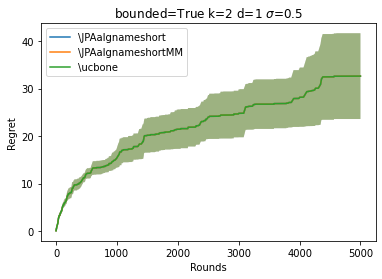

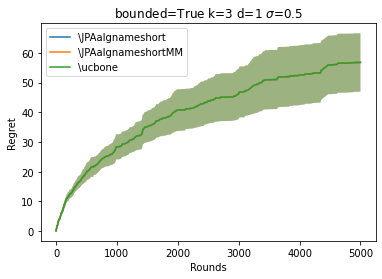

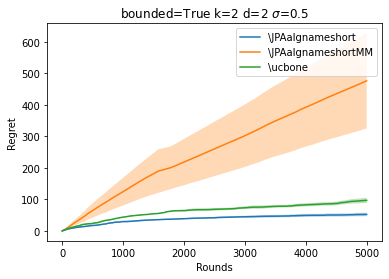

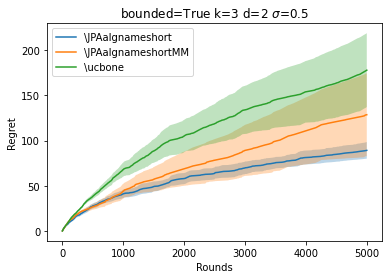

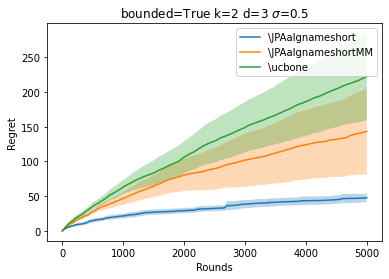

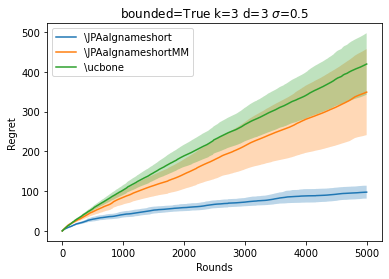

In [19]:
# BASIC SETTING FOR EXPERIMENTS
fucb = '\\JPAalgnameshort'
fucbMM = '\\JPAalgnameshortMM'
ucbone = '\\ucbone'
httem = '\\httem'
algs = [fucb, ucbone, httem, fucbMM]
T = 10000
checkpoints = [1000, 5000, 10000]
n_trials = 10
seed = 0
k_list = [3, 4, 5]
d_list = [1, 2, 3, 4]
bounded_list = [True, False]   
do_subsampling = True

# OVERRIDE FOR TESTING PURPOSE TO SPEED UP THE RUNS
T = 5000
checkpoints = [1000, 2000, 5000]
bounded_list = [True] 
algs = [fucb, fucbMM, ucbone]
n_trials = 5
k_list = [2, 3]
d_list = [1, 2, 3]
do_subsampling = False
    
result_table = {}

for bounded in bounded_list:

    result_table[bounded] = {}
    
    if bounded: 
        sigma = 0.5 # fixed for bernoulli
    else:
        sigma = 0.1
    
    for d in d_list:

        result_table[bounded][d] = {}

        for k in k_list:

            result_table[bounded][d][k] = {}

            arms_vect = k * np.ones(d, dtype=int)

            # F-UCB INIT
            agent_factored = FactoredUCBAgent(arms_vect, d, sigma)

            # F-UCB-MM INIT
            agent_factored_MM = FactoredUCBAgentMM(k, d, T)
            
            # UCB1 INIT
            agent_ucb = UCB1Agent(d*k, sigma)
            action_mx = create_action_matrix(d, k)

            # HT-TEM INIT
            agent_ht_tem = TMRobustUCBAgent(d*k, 1, 1)
            
            mean_cum_expected_regret = {}
            std_cum_expected_regret = {}
            
            for alg in algs:

                result_table[bounded][d][k][alg] = {}

                env = FactoredEnv(arms_vect, d, sigma=sigma, bounded=bounded)

                inst_expected_regret = np.zeros((n_trials, T))
                
                # for trial_i in range(n_trials):
                for trial_i in tqdm(range(n_trials)):
                
                    vals_expected = env.get_expected()
                    max_expected = compute_max_expected(vals_expected)

                    for t in range(T):

                        if alg == ucbone:
                            action = action_mx[agent_ucb.pull_arm(), :]
                            agent_ucb.update(np.prod(env.step(action)))
                        elif alg == fucb:
                            action = agent_factored.pull_arm()
                            agent_factored.update(env.step(action))
                        elif alg == fucbMM:
                            action = agent_factored_MM.pull_arm()
                            agent_factored_MM.update(env.step(action))
                        elif alg == httem:
                            action = action_mx[agent_ht_tem.pull_arm(), :]
                            agent_ht_tem.update(np.prod(env.step(action)))
                        else:
                            raise ValueError('Error in selecting algorithm')

                        inst_expected_regret[trial_i, t] = max_expected - get_pulled_expected(
                            vals_expected, action)
                    
                    # I reset all the agents, becuase i do not know which one 
                    # i am using for the sake of simplicity
                    agent_ucb.reset()
                    agent_factored.reset()
                    agent_factored_MM.reset()
                    agent_ht_tem.reset()
                    
                    if trial_i < n_trials - 1:
                        env.reset()
                
                # maybe replace with cumsum with correct axis
                cum_expected_regret = np.zeros(inst_expected_regret.shape)
                cum_expected_regret[:, 0] = inst_expected_regret[:, 0]
                for i in range(1, T):
                    cum_expected_regret[:, i] = inst_expected_regret[:, i] + cum_expected_regret[:, i-1]

                mean_cum_expected_regret[alg] = np.mean(cum_expected_regret, axis=0)
                std_cum_expected_regret[alg] = np.std(cum_expected_regret, axis=0) / np.sqrt(n_trials)

                print('{} run completed - k={} d={} $\sigma$={}'.format(alg, k, d, sigma))
                for i in checkpoints:
                    result_table[bounded][d][k][alg][i] = '${} \ ({})$   '.format(
                        round(mean_cum_expected_regret[alg][i-1], 2), 
                        round(std_cum_expected_regret[alg][i-1], 2)
                    )
                    print('T={}: ${} \ ({})$'.format(i, round(mean_cum_expected_regret[alg][i-1], 2), 
                                                  round(std_cum_expected_regret[alg][i-1], 2)))

            plt.figure()
            if do_subsampling:
                subsample = 50
                assert T % subsample == 0
                x_plt = np.linspace(0, T-1, int(T/subsample), dtype=int)
            else:
                x_plt = np.linspace(0, T-1, T, dtype=int)
            for alg in algs:
                plt.plot(x_plt, mean_cum_expected_regret[alg][x_plt], 
                         label=alg)
                plt.fill_between(x_plt, 
                                 mean_cum_expected_regret[alg][x_plt] - std_cum_expected_regret[alg][x_plt], 
                                 mean_cum_expected_regret[alg][x_plt] + std_cum_expected_regret[alg][x_plt], 
                                 alpha=0.3)
            plt.legend()
            plt.xlabel('Rounds')
            plt.ylabel('Regret')
            plt.title('bounded={} k={} d={} $\sigma$={}'.format(bounded, k, d, sigma))
            if bounded:
                save_str = 'results/bounded_k{}_d{}'.format(k, d)
            else:
                save_str = 'results/subgauss_k{}_d{}'.format(k, d)
            # plt.savefig(save_str + '.png')
            # tkz.save(save_str + '.tex')

In [5]:
print('d= \t k= \t T=\t\t', end='')
[print(alg, end='\t\t\t') for alg in algs]
print('')

for d in d_list:
    for k in k_list:
        for T_val in checkpoints:
            print('${}$ & \t ${}$ & \t ${}$ \t\t'.format(d, k, T_val), end='')
            for bounded in bounded_list:
                for alg in algs:
                    print('&', result_table[bounded][d][k][alg][T_val], end='\t')
            if T_val == checkpoints[-1]:
                print('\\\\\n\\cmidrule{2-9}')
            else:
                print('\\\\\n\\cmidrule{3-9}')
    print('\cmidrule{1-9}')

d= 	 k= 	 T=		\JPAalgnameshort			\JPAalgnameshortMM			\ucbone			
$1$ & 	 $2$ & 	 $1000$ 		& $15.42 \ (2.06)$   	& $15.42 \ (2.06)$   	& $15.42 \ (2.06)$   	\\
\cmidrule{3-9}
$1$ & 	 $2$ & 	 $2000$ 		& $21.45 \ (4.13)$   	& $21.45 \ (4.13)$   	& $21.45 \ (4.13)$   	\\
\cmidrule{3-9}
$1$ & 	 $2$ & 	 $5000$ 		& $32.61 \ (9.02)$   	& $32.61 \ (9.02)$   	& $32.61 \ (9.02)$   	\\
\cmidrule{2-9}
$1$ & 	 $3$ & 	 $1000$ 		& $28.37 \ (4.2)$   	& $28.37 \ (4.2)$   	& $28.37 \ (4.2)$   	\\
\cmidrule{3-9}
$1$ & 	 $3$ & 	 $2000$ 		& $40.75 \ (7.01)$   	& $40.75 \ (7.01)$   	& $40.75 \ (7.01)$   	\\
\cmidrule{3-9}
$1$ & 	 $3$ & 	 $5000$ 		& $56.8 \ (9.81)$   	& $56.8 \ (9.81)$   	& $56.8 \ (9.81)$   	\\
\cmidrule{2-9}
\cmidrule{1-9}
$2$ & 	 $2$ & 	 $1000$ 		& $29.59 \ (2.53)$   	& $124.67 \ (44.07)$   	& $43.75 \ (1.62)$   	\\
\cmidrule{3-9}
$2$ & 	 $2$ & 	 $2000$ 		& $38.52 \ (1.88)$   	& $218.67 \ (73.4)$   	& $64.53 \ (2.74)$   	\\
\cmidrule{3-9}
$2$ & 	 $2$ & 	 $5000$ 		& $52.41 \ (5.59)$   	& $4